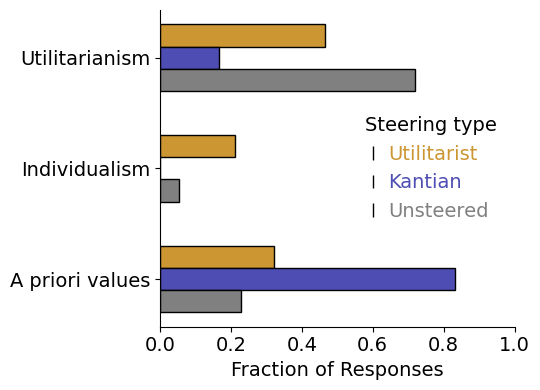

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dat_steer = pd.read_csv('Dilemmas_Results/Dilemmas - Ethical School Classification - Steered Gemini-2B.csv', sep=';')

# Add Layer column
layer_col = []
layer_count = 0

for i, row in dat_steer.iterrows():
    if row['Utilitarist'] == 'Nan' and row['Kantian'] == 'Nan':
        layer_count += 1
    layer_col.append(layer_count)

dat_steer['Layer'] = layer_col

# Melt the dataframe for easier plotting
df_melted = dat_steer.melt(id_vars=['Layer'], value_vars=['Utilitarist', 'Kantian'], var_name='Category', value_name='Response')

# Remove rows where Response is NaN or '-'
df_melted = df_melted[~df_melted['Response'].isin(['Nan', pd.NA])]

# Aggregate responses over all layers for each category and compute fractions
agg_counts = df_melted.groupby(['Category', 'Response']).size().reset_index(name='Counts')
total_counts = agg_counts.groupby('Category')['Counts'].sum().reset_index(name='Total')
agg_counts = agg_counts.merge(total_counts, on='Category')
agg_counts['Fraction'] = agg_counts['Counts'] / agg_counts['Total']

# Ensure all categories are present in each subplot
all_categories_eng = ['Rule Utilitarianism', 'Act Utilitarianism', 'Classical Virtue Ethics', 'Theory of Rights', 
                      'Prima Facie Duties', 'Ethical Altruism', 'Classical Deontology', 'Ethical Egoism']
missing_entries = []
for category in ['Utilitarist', 'Kantian']:
    for response in all_categories_eng:
        if not ((agg_counts['Category'] == category) & (agg_counts['Response'] == response)).any():
            missing_entries.append({'Category': category, 'Response': response, 'Counts': 0, 'Total': total_counts[total_counts['Category'] == category]['Total'].values[0], 'Fraction': 0})

if missing_entries:
    missing_df = pd.DataFrame(missing_entries)
    agg_counts = pd.concat([agg_counts, missing_df], ignore_index=True)

# Calculate the mean and standard deviation of the fractions by layer
layered_fractions = df_melted.groupby(['Layer', 'Category', 'Response']).size().reset_index(name='Counts')
total_layer_counts = layered_fractions.groupby(['Layer', 'Category'])['Counts'].sum().reset_index(name='Total')
layered_fractions = layered_fractions.merge(total_layer_counts, on=['Layer', 'Category'])
layered_fractions['Fraction'] = layered_fractions['Counts'] / layered_fractions['Total']

# Calculate standard deviations
response_sd = layered_fractions.groupby(['Category', 'Response'])['Fraction'].std().reset_index(name='StdDev')

# Merge standard deviations into aggregated counts
agg_counts = agg_counts.merge(response_sd, on=['Category', 'Response'], how='left').fillna(0)

# Convert 'Response' column to categorical with the specified order
agg_counts['Response'] = pd.Categorical(agg_counts['Response'], categories=all_categories_eng, ordered=True)


# Baseline values
unsteered = {
    'Rule Utilitarianism': 0.12,
    'Act Utilitarianism': 0.107,
    'Classical Virtue Ethics': 0.28,
    'Theory of Rights': 0.133,
    'Prima Facie Duties': 0.107,
    'Ethical Altruism': 0.0534,
    'Classical Deontology': 0.2,
    'Ethical Egoism': 0.0
}
grouped_baseline = {
    'Utilitarianism': unsteered['Rule Utilitarianism'] + unsteered['Act Utilitarianism'],
    'Individualism': unsteered['Ethical Egoism'] + unsteered['Ethical Altruism'],
    'A priori values': unsteered['Classical Virtue Ethics'] + unsteered['Classical Deontology'] + unsteered['Prima Facie Duties'] + unsteered['Theory of Rights']
}
# Group responses into the three main categories
agg_counts['Group'] = agg_counts['Response'].map({
    'Rule Utilitarianism': 'Utilitarianism',
    'Act Utilitarianism': 'Utilitarianism',
    'Ethical Egoism': 'Individualism',
    'Ethical Altruism': 'Individualism',
    'Classical Virtue Ethics': 'A priori values',
    'Classical Deontology': 'A priori values',
    'Prima Facie Duties': 'A priori values',
    'Theory of Rights': 'A priori values',
})

# Remove rows with no group
agg_counts = agg_counts.dropna(subset=['Group'])

# Sum the fractions for each group
grouped_counts = agg_counts.groupby(['Category', 'Group']).agg({
    'Fraction': 'sum',
    'Counts': 'sum'
}).reset_index()

# Grouped counts to plot
grouped_utilitarianism = grouped_counts[grouped_counts['Group'] == 'Utilitarianism']
grouped_theory_of_rights = grouped_counts[grouped_counts['Group'] == 'Individualism']
grouped_a_priori_values = grouped_counts[grouped_counts['Group'] == 'A priori values']

# Baseline values
baseline_values = {
    'Utilitarianism': grouped_baseline['Utilitarianism'],
    'Individualism': grouped_baseline['Individualism'],
    'A priori values': grouped_baseline['A priori values']
}

# Set up the plot
fig, ax = plt.subplots(figsize=(5.5,4))

# Define the colors
colors = {
    'Baseline': 'gray',
    'Kantian': 'blue',
    'Utilitarist': 'orange'
}

# Define bar heights and offsets
bar_height = 0.4
offset =0.2


ax.barh(y=[2 + (2*offset), 1 + (2*offset), 0 + (2*offset)], width=[
    grouped_utilitarianism[grouped_utilitarianism['Category'] == 'Utilitarist']['Fraction'].values[0],
    grouped_theory_of_rights[grouped_theory_of_rights['Category'] == 'Utilitarist']['Fraction'].values[0],
    grouped_a_priori_values[grouped_a_priori_values['Category'] == 'Utilitarist']['Fraction'].values[0]
], color=sns.desaturate(colors['Utilitarist'], 0.6), height=bar_height / 2, label='Utilitarist', edgecolor='black')

ax.barh(y=[2 + offset, 1 + offset, 0 + offset], width=[
    grouped_utilitarianism[grouped_utilitarianism['Category'] == 'Kantian']['Fraction'].values[0],
    grouped_theory_of_rights[grouped_theory_of_rights['Category'] == 'Kantian']['Fraction'].values[0],
    grouped_a_priori_values[grouped_a_priori_values['Category'] == 'Kantian']['Fraction'].values[0]
], color=sns.desaturate(colors['Kantian'], 0.4), height=bar_height / 2, label='Kantian', edgecolor='black')


# Plot Baseline values
ax.barh(y=['Utilitarianism', 'Individualism', 'A priori values'], width=list(baseline_values.values()), 
        color=sns.desaturate(colors['Baseline'], 0.6), edgecolor='black', height=0.2, label='Unsteered')

# Configure the plot
ax.set_yticks(np.array([0, 1, 2])+0.2)
ax.set_yticklabels(['A priori values', 'Individualism', 'Utilitarianism'], fontsize=14)
ax.set_xlabel('Fraction of Responses', fontsize=14)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 6), np.linspace(0, 1, 6).round(1), fontsize=14)
ax.legend(title='Steering type', fontsize=14, title_fontsize=14, frameon = False, handlelength = 0, labelcolor = 'linecolor')
plt.tight_layout()
sns.despine()
#plt.savefig('SteeringResults_Aggregated_21052024.svg', transparent = True)

In [2]:
# Melt the dataframe for easier plotting
df_melted = dat_steer.melt(id_vars=['Layer'], value_vars=['Utilitarist', 'Kantian'], var_name='Category', value_name='Response')

# Remove rows where Response is NaN or '-'
df_melted = df_melted[~df_melted['Response'].isin(['Nan', pd.NA])]

# Aggregate responses within each layer for each category and compute fractions
agg_counts_layer = df_melted.groupby(['Layer', 'Category', 'Response']).size().reset_index(name='Counts')
total_counts_layer = agg_counts_layer.groupby(['Layer', 'Category'])['Counts'].sum().reset_index(name='Total')
agg_counts_layer = agg_counts_layer.merge(total_counts_layer, on=['Layer', 'Category'])
agg_counts_layer['Fraction'] = agg_counts_layer['Counts'] / agg_counts_layer['Total']

# Ensure all categories are present in each subplot
all_categories_eng = ['Rule Utilitarianism', 'Act Utilitarianism', 'Classical Virtue Ethics', 'Theory of Rights', 
                      'Prima Facie Duties', 'Ethical Altruism', 'Classical Deontology', 'Ethical Egoism']
missing_entries_layer = []
for layer in agg_counts_layer['Layer'].unique():
    for category in ['Utilitarist', 'Kantian']:
        for response in all_categories_eng:
            if not ((agg_counts_layer['Layer'] == layer) & (agg_counts_layer['Category'] == category) & (agg_counts_layer['Response'] == response)).any():
                missing_entries_layer.append({'Layer': layer, 'Category': category, 'Response': response, 'Counts': 0, 'Total': total_counts_layer[(total_counts_layer['Layer'] == layer) & (total_counts_layer['Category'] == category)]['Total'].values[0], 'Fraction': 0})

if missing_entries_layer:
    missing_df_layer = pd.DataFrame(missing_entries_layer)
    agg_counts_layer = pd.concat([agg_counts_layer, missing_df_layer], ignore_index=True)

# Add the Group column

agg_counts_layer['Group'] = agg_counts_layer['Response'].map({
    'Rule Utilitarianism': 'Utilitarianism',
    'Act Utilitarianism': 'Utilitarianism',
    'Ethical Egoism': 'Individualism',
    'Ethical Altruism': 'Individualism',
    'Classical Virtue Ethics': 'A priori values',
    'Classical Deontology': 'A priori values',
    'Prima Facie Duties': 'A priori values',
    'Theory of Rights': 'A priori values',
})

# Remove rows with no group
agg_counts_layer = agg_counts_layer.dropna(subset=['Group'])

# Sum the fractions for each group within each layer
grouped_counts_layer = agg_counts_layer.groupby(['Layer', 'Category', 'Group']).agg({
    'Fraction': 'sum',
    'Counts': 'sum'
}).reset_index()

# Baseline values
baseline_values = {
    'Utilitarianism': 0.12 + 0.107,
    'Egoism': 0.133 + 0.054,
    'A priori values': 0.28 + 0.2 + 0.107
}

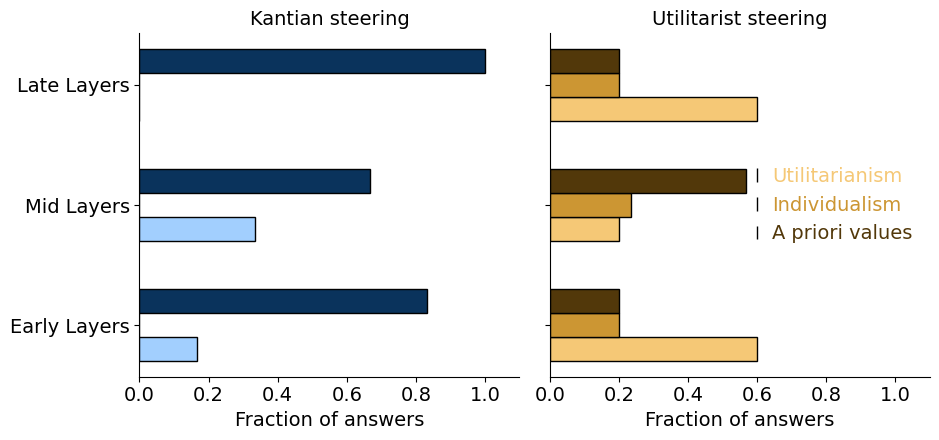

In [3]:
# Pooling the layers into three groups
def pool_layers(df, layer_groups):
    pooled_df = pd.DataFrame()
    for group_name, layers in layer_groups.items():
        group_data = df[df['Layer'].isin(layers)].groupby(['Category', 'Group']).agg({
            'Fraction': 'mean'
        }).reset_index()
        group_data['Layer_Group'] = group_name
        pooled_df = pd.concat([pooled_df, group_data], ignore_index=True)
    return pooled_df

# Define layer groups
layer_groups = {
    'Early Layers (1-6)': list(range(1, 7)),
    'Intermediate Layers (7-12)': list(range(7, 13)),
    'Late Layers (13-17)': list(range(13, 18))
}

# Pool the data
pooled_data = pool_layers(grouped_counts_layer, layer_groups)

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(9.5,4.5), sharey=True)

# Define the colors for the categories
category_colors = {
    'Utilitarianism': '#a2cffe',
    'Individualism': '#4989cc',
    'A priori values': '#0a335c'
}

category_colors2 = {
    'Utilitarianism': '#f5c876',
    'Individualism': '#cc9633',
    'A priori values': '#52380a'
}

category_colorss = [category_colors, category_colors2]

# Define bar heights and offsets
bar_height = 0.2
width = 0.2
group_positions = {
    'Early Layers': -width,
    'Mid Layers': 0,
    'Late Layers': width
}

# Plot for each steering type
for i, category in enumerate(['Kantian', 'Utilitarist']):
    ax = axes[i]

    for jj, group_name in enumerate(layer_groups.keys()):
        group_data = pooled_data[(pooled_data['Category'] == category) & (pooled_data['Layer_Group'] == group_name)]

        # Plot Utilitarianism bars
        if not group_data[group_data['Group'] == 'Utilitarianism'].empty:
            utilitarianism_width = group_data[group_data['Group'] == 'Utilitarianism']['Fraction'].values[0]
            ax.barh(y=jj-bar_height, width=utilitarianism_width, color=category_colorss[i]['Utilitarianism'], edgecolor='black',
                    height=bar_height, label='Utilitarianism' if group_name == 'Early Layers (1-6)' else "")

        # Plot Egoism bars
        if not group_data[group_data['Group'] == 'Individualism'].empty:
            theory_of_rights_width = group_data[group_data['Group'] == 'Individualism']['Fraction'].values[0]
            ax.barh(y=jj, width=theory_of_rights_width, color=category_colorss[i]['Individualism'], edgecolor='black',
                    height=bar_height, label='Individualism' if group_name == 'Early Layers (1-6)' else "")

        # Plot A priori values bars
        if not group_data[group_data['Group'] == 'A priori values'].empty:
            a_priori_values_width = group_data[group_data['Group'] == 'A priori values']['Fraction'].values[0]
            ax.barh(y=jj+bar_height, width=a_priori_values_width, color=category_colorss[i]['A priori values'], edgecolor='black',
                    height=bar_height, label='A priori values' if group_name == 'Early Layers (1-6)' else "")

    # Configure the subplot
    ax.set_yticks([0,1,2], list(group_positions.keys()))
    ax.set_xlim(0, 1.1)
    ax.set_xticks(np.linspace(0, 1, 6), np.linspace(0, 1, 6).round(1), fontsize=14)
    ax.set_title(category+' steering', fontsize=14)
    ax.set_xlabel('Fraction of answers', fontsize=14)
    ax.set_yticklabels(list(group_positions.keys()), fontsize=14)

axes[1].legend(fontsize=14, title_fontsize=14, frameon=False, handlelength=0, labelcolor='linecolor')
plt.tight_layout()
sns.despine()
#plt.savefig('SteeringResults_PooledLayers_21052024.svg', transparent = True)